In [1]:
import pandas as pd
from util import get_data, plot_data
from indicators import *
import datetime as dt

In [2]:
def RSI(df: pd.DataFrame, window=14)->pd.DataFrame:
    # Calculate daily returns
    daily_returns = df.diff()
    # Calculate up days and down days
    up_days = daily_returns.where(daily_returns > 0, 0)
    down_days = -daily_returns.where(daily_returns < 0, 0)
    # Calculate average gain and average loss
    avg_gain = up_days.rolling(window=window).mean()
    avg_loss = down_days.rolling(window=window).mean()
    # Calculate relative strength
    rs = avg_gain / (avg_loss + 1e-10)
    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    return rsi


def BollingerBands(df: pd.DataFrame, symbol: str, window=20, num_std=2) -> pd.DataFrame:
    rolling_mean = df[symbol].rolling(window=window).mean()
    rolling_std = df[symbol].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    bbp = (df[symbol] - lower_band) / (upper_band - lower_band)

    # Create a DataFrame that contains the original price, rolling mean, upper band, lower band, and signals
    df_bollinger = pd.DataFrame({
        str(symbol): df[symbol],
        'Rolling Mean': rolling_mean,
        'Upper Band': upper_band,
        'Lower Band': lower_band,
        'Signal': bbp
    })

    return df_bollinger


def MACD(df: pd.DataFrame, symbol: str, short_window=12, long_window=26, signal_window=9)->pd.DataFrame:
    # Calculate the short / long term exponential moving average (short_window EMA)
    short_ema = df[symbol].ewm(span=short_window, adjust=False).mean()
    long_ema = df[symbol].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    histogram = macd - signal
    buy_signal = (macd.shift(1) < signal.shift(1)) & (macd > signal)
    sell_signal = (macd.shift(1) > signal.shift(1)) & (macd < signal)
    df_macd = pd.DataFrame({'MACD': macd, 'Signal Line': signal, 'Histogram': histogram, 'Buy Signal': buy_signal, 'Sell Signal': sell_signal})

    return df_macd

In [2]:
sd = dt.datetime(2010,1,1)
ed = dt.datetime(2011, 12, 31)
symbol = 'JPM'
dates = pd.date_range(sd, ed)

In [46]:

sd = dt.datetime(2010,1,1)
ed = dt.datetime(2011, 12, 31)
symbol = 'JPM'
dates = pd.date_range(sd, ed)

adjusted_close_prices = get_data([symbol], pd.date_range(sd, ed), addSPY=False).dropna()
# Build up the dataframe
adjusted_close_prices.index.name = 'Date'
output_df = pd.DataFrame(index=adjusted_close_prices.index)
output_df[symbol] = adjusted_close_prices[symbol]
output_df['RSI'] = RSI(output_df[symbol])
output_df['BollingerBands'] = BollingerBands(output_df,symbol)['Signal']
output_df['MACD_buy'] = MACD(output_df, symbol)['Buy Signal']
output_df['MACD_sell'] = MACD(output_df, symbol)['Sell Signal']


In [47]:
output_df

,JPM,RSI,BollingerBands,MACD_buy,MACD_sell
Date,,,,,
2010-01-04,40.87,NaN,NaN,False,False
2010-01-05,41.67,NaN,NaN,False,False
2010-01-06,41.89,NaN,NaN,False,False
2010-01-07,42.72,NaN,NaN,False,False
2010-01-08,42.62,NaN,NaN,False,False
...,...,...,...,...,...
2011-12-23,32.84,50.296443,0.785523,False,False
2011-12-27,32.31,49.036609,0.674845,False,False
2011-12-28,31.94,43.400000,0.582428,False,False


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


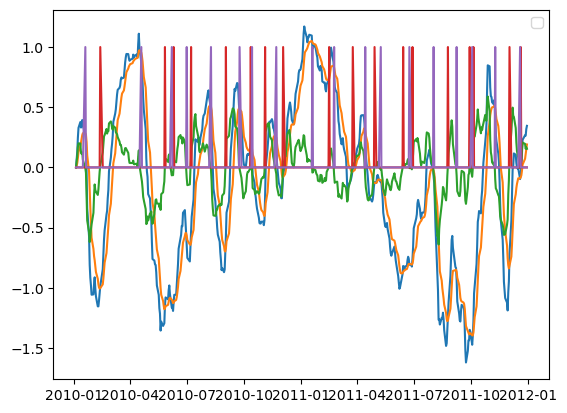

In [48]:
df = MACD(output_df, symbol)
import matplotlib.pyplot as plt
plt.plot(df)
plt.legend()
plt.show()

<AxesSubplot:xlabel='Date'>

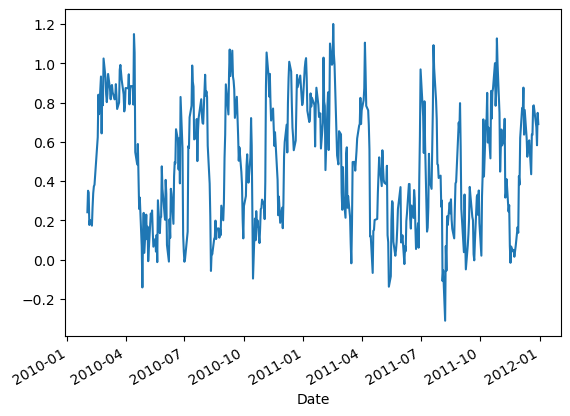

In [49]:
output_df['BollingerBands'].plot()

In [50]:
df[df['Sell Signal'] == False]

,MACD,Signal Line,Histogram,Buy Signal,Sell Signal
Date,,,,,
2010-01-04,0.000000,0.000000,0.000000,False,False
2010-01-05,0.063818,0.012764,0.051054,False,False
2010-01-06,0.130640,0.036339,0.094301,False,False
2010-01-07,0.247715,0.078614,0.169101,False,False
2010-01-08,0.328641,0.128620,0.200022,False,False
...,...,...,...,...,...
2011-12-23,0.229039,0.022905,0.206133,False,False
2011-12-27,0.267051,0.071734,0.195317,False,False
2011-12-28,0.264274,0.110242,0.154032,False,False


In [51]:
import pandas as pd

flag = 0  # 0: no position, 1: long, -1: short
index = 0
trades = pd.DataFrame(columns=['Date', 'Symbol', 'Shares'])

for i in range(0, len(output_df) - 1):
    if flag == 0:  # No position
        if output_df['RSI'].iloc[i] < 30 or output_df['BollingerBands'].iloc[i] < 0.2 or output_df['MACD_buy'].iloc[i] == True:
            trade = pd.DataFrame({'Date': [output_df.index[i]], 'Symbol': [symbol], 'Shares': [1000]})
            trades = pd.concat([trades, trade], ignore_index=True)
            flag = 1  # Enter long position
            index += 1
        elif output_df['RSI'].iloc[i] > 70 or output_df['BollingerBands'].iloc[i] > 0.8 or output_df['MACD_sell'].iloc[i]  == True:
            trade = pd.DataFrame({'Date': [output_df.index[i]], 'Symbol': [symbol], 'Shares': [-1000]})
            trades = pd.concat([trades, trade], ignore_index=True)
            flag = -1  # Enter short position
            index += 1
        else:
            trade = pd.DataFrame({'Date': [output_df.index[i]], 'Symbol': [symbol], 'Shares': [0]})
            trades = pd.concat([trades, trade], ignore_index=True)
            index += 1

    elif flag == -1:  # Short position
        if output_df['RSI'].iloc[i] < 25 or output_df['BollingerBands'].iloc[i] < 0.15:
            trade = pd.DataFrame({'Date': [output_df.index[i]], 'Symbol': [symbol], 'Shares': [2000]})
            trades = pd.concat([trades, trade], ignore_index=True)
            flag = 1  # Exit short and go long
            index += 1
        elif output_df['RSI'].iloc[i] < 30 or output_df['BollingerBands'].iloc[i] < 0.2 or output_df['MACD_buy'].iloc[i]  == True:
            trade = pd.DataFrame({'Date': [output_df.index[i]], 'Symbol': [symbol], 'Shares': [1000]})
            trades = pd.concat([trades, trade], ignore_index=True)
            flag = 0  # Exit short and go neutral
            index += 1
        else:
            trade = pd.DataFrame({'Date': [output_df.index[i]], 'Symbol': [symbol],'Shares': [0]})
            trades = pd.concat([trades, trade], ignore_index=True)
            index += 1

    elif flag == 1:  # Long position
        if output_df['RSI'].iloc[i] > 75 or output_df['BollingerBands'].iloc[i] > 0.85:
            trade = pd.DataFrame({'Date': [output_df.index[i]], 'Symbol': [symbol], 'Shares': [-2000]})
            trades = pd.concat([trades, trade], ignore_index=True)
            flag = -1  # Exit long and go short
            index += 1
        elif output_df['RSI'].iloc[i] > 70 or output_df['BollingerBands'].iloc[i] > 0.8 or output_df['MACD_sell'].iloc[i]  == True:
            trade = pd.DataFrame({'Date': [output_df.index[i]], 'Symbol': [symbol], 'Shares': [-1000]})
            trades = pd.concat([trades, trade], ignore_index=True)
            flag = 0  # Exit long and go neutral
            index += 1
        else:
            trade = pd.DataFrame({'Date': [output_df.index[i]], 'Symbol': [symbol], 'Shares': [0]})
            trades = pd.concat([trades, trade], ignore_index=True)
            index += 1

# Closing any open positions at the last day
if flag == 1:  # If we are long, sell on the last day
    trade = pd.DataFrame({'Date': [output_df.index[-1]], 'Symbol': [symbol], 'Shares': [-1000]})
    trades = pd.concat([trades, trade], ignore_index=True)
elif flag == -1:  # If we are short, buy on the last day
    trade = pd.DataFrame({'Date': [output_df.index[-1]], 'Symbol': [symbol], 'Shares': [1000]})
    trades = pd.concat([trades, trade], ignore_index=True)
else:
    trade = pd.DataFrame({'Date': [output_df.index[-1]], 'Symbol': [symbol], 'Shares': [0]})
    trades = pd.concat([trades, trade], ignore_index=True)


trades.set_index('Date', inplace=True)
# Drop Symbol column
trades.drop('Symbol', axis=1, inplace=True)

<AxesSubplot:xlabel='Date'>

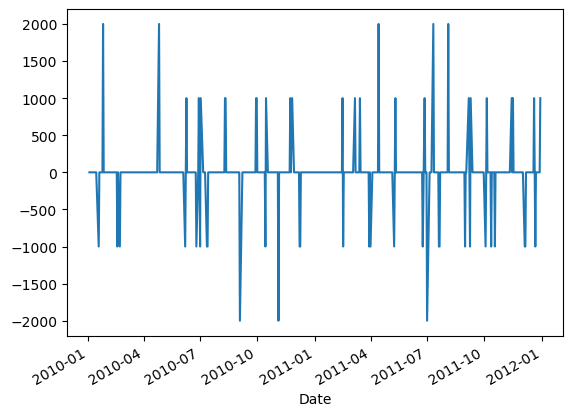

In [80]:
trades['Shares'].plot()

In [52]:
df2 = pd.merge(output_df, trades, how='left', left_index=True, right_on='Date')
df2['BenchmarkOrders'] = 0
df2['BenchmarkOrders'].iloc[0] = 1000
df2

/var/folders/qf/0ntlczhs3rsdnl7s88jk_qcc0000gn/T/ipykernel_58807/3959885622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['BenchmarkOrders'].iloc[0] = 1000


,JPM,RSI,BollingerBands,MACD_buy,MACD_sell,Shares,BenchmarkOrders
Date,,,,,,,
2010-01-04,40.87,NaN,NaN,False,False,0,1000
2010-01-05,41.67,NaN,NaN,False,False,0,0
2010-01-06,41.89,NaN,NaN,False,False,0,0
2010-01-07,42.72,NaN,NaN,False,False,0,0
2010-01-08,42.62,NaN,NaN,False,False,0,0
...,...,...,...,...,...,...,...
2011-12-23,32.84,50.296443,0.785523,False,False,0,0
2011-12-27,32.31,49.036609,0.674845,False,False,0,0
2011-12-28,31.94,43.400000,0.582428,False,False,0,0


In [6]:
"""
An improved version of your marketsim code accepts a “trades” DataFrame (instead of a file). More info on the trades data frame is below. 
It is OK not to submit this file if you have subsumed its functionality into one of your other required code files. 
This file has a different name and a slightly different setup than your previous project. However, that solution can be used with several edits for the new requirements.  
"""

import pandas as pd

def author():
    return "zdong312"

def study_group():
    return "zdong312"

def compute_portvals(data: pd.DataFrame, symbol: str, start_val: float = 1_000_000, commission_fee: float = 9.95, market_impact: float = 0.005, use_benchmark: bool = False) -> pd.Series:
    # Initialize the portfolio with cash and no shares
    portfolio = {symbol: 0, 'CASH': start_val}
    
    # Use appropriate orders based on the strategy (benchmark or policy)
    if use_benchmark:
        order_series = data["BenchmarkOrders"].sort_index()
    else:
        order_series = data["Shares"].sort_index()

    # Calculate portfolio values across the entire dataset
    portfolio_values = data.apply(lambda row: calculate_daily_portfolio_value(row, order_series, symbol, portfolio, commission_fee, market_impact), axis=1).dropna()

    return portfolio_values

def calculate_daily_portfolio_value(row: pd.Series, orders: pd.Series, symbol: str, portfolio: dict, commission: float, impact: float) -> float:
    # Apply orders for the day if available
    if row.name in orders.index:
        daily_order = orders.loc[row.name]

        # Update the portfolio with the daily order
        apply_order_to_portfolio(daily_order, row, symbol, portfolio, commission, impact)

    # Calculate total portfolio value for the day (cash + stock holdings)
    total_value = portfolio['CASH']
    for stock in portfolio:
        if stock == 'CASH':
            continue
        total_value += portfolio[stock] * row[stock]

    # Store the portfolio value in the row and return it
    row['PortfolioValue'] = total_value
    return total_value

def apply_order_to_portfolio(order_quantity: int, row: pd.Series, symbol: str, portfolio: dict, commission: float, impact: float):
    # Get the stock price for the current row (day)
    stock_price = row[symbol]

    if order_quantity > 0:
        # If buying shares
        portfolio[symbol] += order_quantity
        stock_price *= (1 + impact)  # Adjust price with market impact (increase for buy)
        portfolio['CASH'] -= order_quantity * stock_price
        portfolio['CASH'] -= commission  # Deduct commission fee

    elif order_quantity < 0:
        # If selling shares
        sell_quantity = -order_quantity  # Convert order to positive for selling
        portfolio[symbol] -= sell_quantity
        stock_price *= (1 - impact)  # Adjust price with market impact (decrease for sell)
        portfolio['CASH'] += sell_quantity * stock_price
        portfolio['CASH'] -= commission  # Deduct commission fee

In [85]:
Mannual_portvals = compute_portvals(df2, symbol, start_val=100000, commission_fee=0, market_impact=0, use_benchmark=False)
# benchmark_portvals = compute_portvals(df2, symbol, start_val=100000, commission_fee=0., market_impact=0., use_benchmark=True)
# print(Mannual_portvals)
# print()
# print(benchmark_portvals)

Date
2010-01-04    100000.0
2010-01-05    100000.0
2010-01-06    100000.0
2010-01-07    100000.0
2010-01-08    100000.0
                ...   
2011-12-23    123300.0
2011-12-27    123300.0
2011-12-28    123300.0
2011-12-29    123300.0
2011-12-30    123300.0
Length: 504, dtype: float64

Date
2010-01-04    100000.0
2010-01-05    100800.0
2010-01-06    101020.0
2010-01-07    101850.0
2010-01-08    101750.0
                ...   
2011-12-23     91970.0
2011-12-27     91440.0
2011-12-28     91070.0
2011-12-29     91820.0
2011-12-30     91660.0
Length: 504, dtype: float64


In [7]:
def report_metrics(port_vals: pd.Series, strategy: str) -> None:
    daily_rets = port_vals.copy()
    daily_rets[1:] = (port_vals[1:] / port_vals[:-1].values) - 1
    daily_rets = daily_rets.iloc[1:]
    # Calculate cumulative return, average daily return, and standard deviation of daily return
    cr = (port_vals.iloc[-1] / port_vals.iloc[0]) - 1
    adr = daily_rets.mean()
    sddr = daily_rets.std()
    # Uncomment to print metrics
    print("Cumulative Return of {}: {:.6f}".format(strategy, cr))
    print("Standard Deviation of {}: {:.6f}".format(strategy, sddr))
    print("Average Daily Return of {}: {:.6f}".format(strategy, adr))
    print()

In [27]:
Mannual_portvals.iloc[0]

100000.0

In [87]:
report_metrics(Mannual_portvals, 'Manual Strategy')
normed_manual = Mannual_portvals / Mannual_portvals.iloc[0]
report_metrics(benchmark_portvals, 'Benchmark')
normed_benchmark = benchmark_portvals / benchmark_portvals.iloc[0]
df_temp = pd.concat([normed_benchmark, normed_manual], axis=1)
df_temp.columns = ['Benchmark', 'Manual Strategy']
plot_data(df_temp, title=f"{symbol} Manual Strategy vs Benchmark", xlabel="Date", ylabel="Portfoio Value")

Cumulative Return of Manual Strategy: 0.233000
Standard Deviation of Manual Strategy: 0.006964
Average Daily Return of Manual Strategy: 0.000441

Cumulative Return of Benchmark: -0.083400
Standard Deviation of Benchmark: 0.008481
Average Daily Return of Benchmark: -0.000137



<AxesSubplot:xlabel='Date'>

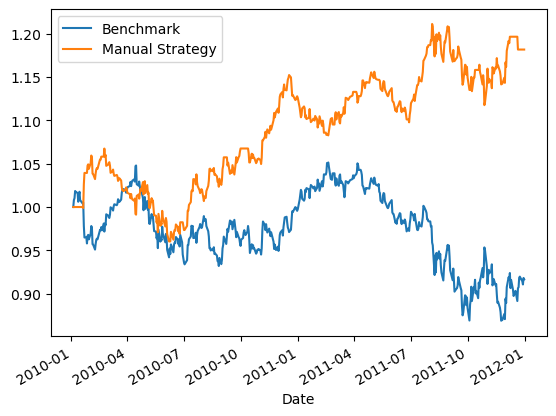

In [86]:
df_temp.plot()

# Strategy Learner

In [22]:
output_df

,JPM,RSI,BollingerBands,MACD_buy,MACD_sell
Date,,,,,
2010-01-04,40.87,NaN,NaN,False,False
2010-01-05,41.67,NaN,NaN,False,False
2010-01-06,41.89,NaN,NaN,False,False
2010-01-07,42.72,NaN,NaN,False,False
2010-01-08,42.62,NaN,NaN,False,False
...,...,...,...,...,...
2011-12-23,32.84,50.296443,0.785523,False,False
2011-12-27,32.31,49.036609,0.674845,False,False
2011-12-28,31.94,43.400000,0.582428,False,False


In [40]:
import BagLearner as bl
import RTLearner as rt
import numpy as np

#TODO Should use 2008 - 2010 for train
learner = bl.BagLearner(learner=rt.RTLearner, kwargs={"leaf_size": 5}, bags=20, boost=False, verbose=False)
Dataset_df = output_df.copy()
Dataset_df.fillna(0, inplace=True)
trainX = Dataset_df[:-5].values # remove last 5 days for prediction
trainY = []
impact = 0.0
price = output_df[symbol].values
# We predict the price after 5 days
for i in range(len(Dataset_df)-5):
    ratio = (price[i+5]-price[i])/price[i]
    if ratio > (0.02 + impact): # if price increase more than 2%, we buy
        trainY.append(1)
    elif ratio < (-0.02 - impact): # if price decrease more than 2%, we sell
        trainY.append(-1)
    else:
        trainY.append(0) # hold
trainY=np.array(trainY)
learner.add_evidence(trainX, trainY)
trainY

array([ 1,  0,  0,  0, -1, -1,  0, -1, -1, -1, -1, -1, -1,  0,  0,  1,  1,
       -1,  0, -1, -1, -1,  0,  0,  1,  1,  1,  1,  1,  0,  1,  0,  1,  1,
        1,  0,  1,  1,  0,  0,  1,  1,  0,  0,  0,  1,  0,  0,  0,  1,  1,
        1,  1,  1,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  1,  1,  0,  0,
        0, -1, -1,  0, -1, -1, -1,  0, -1,  0,  0,  0, -1, -1, -1, -1, -1,
        0, -1, -1, -1, -1, -1,  0, -1,  0,  0,  1,  0,  0,  0,  0, -1, -1,
        0, -1, -1,  0,  0,  0,  1,  0,  1,  1,  0,  0,  0,  0,  0, -1, -1,
       -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  0,  0, -1, -1, -1,  1,  1,
        1,  1,  1,  0,  1,  0,  1,  1,  0, -1, -1, -1, -1, -1, -1, -1,  0,
        0,  0, -1, -1, -1, -1,  0, -1,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  0,  0,  0, -1, -1,  0, -1, -1, -1, -1, -1,  0,  0,  1,
        1,  0,  1,  0,  0, -1, -1, -1, -1, -1, -1,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  1,  1,  1,  1,  1,  0, -1,  0,  0, -1,  0,  0, -1, -1,
       -1, -1, -1, -1,  0

In [41]:
trainY.shape

(499,)

In [12]:
#TODO Should use 2010 - 2012 for test
testX = Dataset_df.values

testY = learner.query(testX) # Prediction
testY

trades = pd.DataFrame(index=output_df.index, columns=['Shares']).fillna(0)
flag = 0
for i in range(0,len(trade)-1):
    if flag==0:
        if testY[i]>0:
            trades.values[i] = 1000
            flag = 1
        elif testY[i]<0:
            trades.values[i] = -1000
            flag = -1
        else:
            trades.values[i] = 0
            flag = 0

    elif flag==1:
        if testY[i]<0:
            trades.values[i]=-2000
            flag=-1
        elif testY[i]==0:
            trades.values[i]=-1000
            flag = 0
        else:
            trades.values[i]=0
            flag=1

    else:
        if testY[i]>0:
            trades.values[i]=2000
            flag=1
        elif testY[i]==0:
            trades.values[i]=1000
            flag=0
        else:
            trades.values[i]=0
            flag=-1

if flag==-1:
    trades.values[len(trade)-1]=1000
elif flag==1:
    trades.values[len(trade)-1]=-1000
else:
    trades.values[len(trade)-1]=0

trades.name = "Shares"
trades

,Shares
Date,
2010-01-04,-1000
2010-01-05,0
2010-01-06,0
2010-01-07,0
2010-01-08,0
...,...
2011-12-23,0
2011-12-27,0
2011-12-28,0


In [13]:
output_df

,JPM,RSI,BollingerBands,MACD_buy,MACD_sell
Date,,,,,
2010-01-04,40.87,NaN,NaN,False,False
2010-01-05,41.67,NaN,NaN,False,False
2010-01-06,41.89,NaN,NaN,False,False
2010-01-07,42.72,NaN,NaN,False,False
2010-01-08,42.62,NaN,NaN,False,False
...,...,...,...,...,...
2011-12-23,32.84,50.296443,0.785523,False,False
2011-12-27,32.31,49.036609,0.674845,False,False
2011-12-28,31.94,43.400000,0.582428,False,False


In [14]:
output_df['BenchmarkOrders'] = 0
output_df['BenchmarkOrders'].iloc[0] = 1000
df3 = pd.concat([output_df, trades], axis=1)
df3

/var/folders/qf/0ntlczhs3rsdnl7s88jk_qcc0000gn/T/ipykernel_55685/883616277.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['BenchmarkOrders'].iloc[0] = 1000


,JPM,RSI,BollingerBands,MACD_buy,MACD_sell,BenchmarkOrders,Shares
Date,,,,,,,
2010-01-04,40.87,NaN,NaN,False,False,1000,-1000
2010-01-05,41.67,NaN,NaN,False,False,0,0
2010-01-06,41.89,NaN,NaN,False,False,0,0
2010-01-07,42.72,NaN,NaN,False,False,0,0
2010-01-08,42.62,NaN,NaN,False,False,0,0
...,...,...,...,...,...,...,...
2011-12-23,32.84,50.296443,0.785523,False,False,0,0
2011-12-27,32.31,49.036609,0.674845,False,False,0,0
2011-12-28,31.94,43.400000,0.582428,False,False,0,0


In [15]:
Strategy_portvals = compute_portvals(df3, symbol, start_val=100000, commission_fee=0, market_impact=0, use_benchmark=False)
benchmark_portvals = compute_portvals(df3, symbol, start_val=100000, commission_fee=0., market_impact=0., use_benchmark=True)
print(Strategy_portvals)
print()
print(benchmark_portvals)

Date
2010-01-04    100000.0
2010-01-05     99200.0
2010-01-06     98980.0
2010-01-07     98150.0
2010-01-08     98250.0
                ...   
2011-12-23    186250.0
2011-12-27    186780.0
2011-12-28    187150.0
2011-12-29    186400.0
2011-12-30    186560.0
Length: 504, dtype: float64

Date
2010-01-04    100000.0
2010-01-05    100800.0
2010-01-06    101020.0
2010-01-07    101850.0
2010-01-08    101750.0
                ...   
2011-12-23     91970.0
2011-12-27     91440.0
2011-12-28     91070.0
2011-12-29     91820.0
2011-12-30     91660.0
Length: 504, dtype: float64


In [16]:
report_metrics(Strategy_portvals, 'Strategy Strategy')
normed_strategy = Strategy_portvals / Strategy_portvals.iloc[0]
report_metrics(benchmark_portvals, 'Benchmark')
normed_benchmark = benchmark_portvals / benchmark_portvals.iloc[0]
df_temp2 = pd.concat([normed_benchmark, normed_strategy], axis=1)
df_temp2.columns = ['Benchmark', 'Strategy Strategy']
plot_data(df_temp2, title=f"{symbol} Strategy Strategy vs Benchmark", xlabel="Date", ylabel="Portfoio Value")

Cumulative Return of Strategy Strategy: 0.865600
Standard Deviation of Strategy Strategy: 0.005515
Average Daily Return of Strategy Strategy: 0.001256

Cumulative Return of Benchmark: -0.083400
Standard Deviation of Benchmark: 0.008481
Average Daily Return of Benchmark: -0.000137



<AxesSubplot:xlabel='Date'>

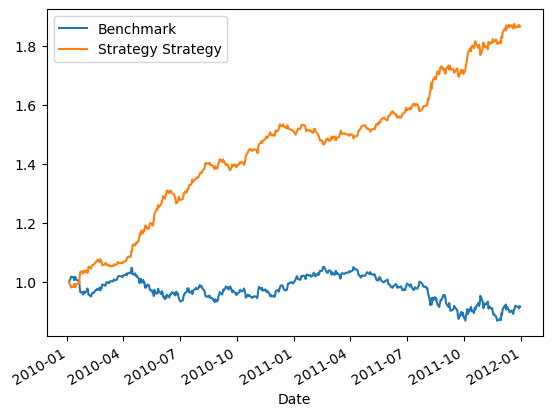

In [17]:
df_temp2.plot()

In [18]:
df_temp2

,Benchmark,Strategy Strategy
Date,,
2010-01-04,1.0000,1.0000
2010-01-05,1.0080,0.9920
2010-01-06,1.0102,0.9898
2010-01-07,1.0185,0.9815
2010-01-08,1.0175,0.9825
...,...,...
2011-12-23,0.9197,1.8625
2011-12-27,0.9144,1.8678
2011-12-28,0.9107,1.8715


## Debug my code in python files


In [11]:
from StrategyLearner import StrategyLearner
import numpy as np
learner = StrategyLearner()
learner.add_evidence(symbol="AAPL", sd=dt.datetime(2008, 1, 1), ed=dt.datetime(2009, 12, 31), sv=10000)


In [12]:
learner

In [26]:
adjusted_close_prices = get_data([symbol], pd.date_range(sd, ed), addSPY=False).dropna()
# Build up the dataframe
adjusted_close_prices.index.name = 'Date'
input_df = pd.DataFrame(index=adjusted_close_prices.index)
input_df[symbol] = adjusted_close_prices[symbol]
input_df['RSI'] = RSI(input_df[symbol])
input_df['BollingerBands'] = BollingerBands(input_df,symbol)['Signal']
input_df['MACD'] = MACD(input_df, symbol)['MACD']
input_df['MACD_Signal_Line'] = MACD(input_df, symbol)['Signal Line']
input_df['MACD_Histogram'] = MACD(input_df, symbol)['Histogram']
input_df_copy = input_df.copy()
input_df.fillna(0, inplace=True)
trainX = input_df[:-5].values # remove last 5 days for prediction
trainY = []
price = input_df[symbol].values

impact = 0.0
for i in range(len(input_df_copy)-5):
    ratio = (price[i+5]-price[i])/price[i]
    if ratio > (0.02 + impact): # if price increase more than 2%, we buy
        trainY.append(1)
    elif ratio < (-0.02 - impact): # if price decrease more than 2%, we sell
        trainY.append(-1)
    else:
        trainY.append(0) # hold
trainY=np.array(trainY)
learner.add_evidence(trainX, trainY)


In [27]:
input_df

,JPM,RSI,BollingerBands,MACD,MACD_Signal_Line,MACD_Histogram
Date,,,,,,
2010-01-04,40.87,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-05,41.67,0.000000,0.000000,0.063818,0.012764,0.051054
2010-01-06,41.89,0.000000,0.000000,0.130640,0.036339,0.094301
2010-01-07,42.72,0.000000,0.000000,0.247715,0.078614,0.169101
2010-01-08,42.62,0.000000,0.000000,0.328641,0.128620,0.200022
...,...,...,...,...,...,...
2011-12-23,32.84,50.296443,0.785523,0.229039,0.022905,0.206133
2011-12-27,32.31,49.036609,0.674845,0.267051,0.071734,0.195317
2011-12-28,31.94,43.400000,0.582428,0.264274,0.110242,0.154032


In [29]:
testX = input_df.values
testX.shape

(504, 6)

In [33]:
testY = learner.query(testX) 
testY.shape

(504,)

In [39]:
input_df

,JPM,RSI,BollingerBands,MACD,MACD_Signal_Line,MACD_Histogram
Date,,,,,,
2010-01-04,40.87,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-05,41.67,0.000000,0.000000,0.063818,0.012764,0.051054
2010-01-06,41.89,0.000000,0.000000,0.130640,0.036339,0.094301
2010-01-07,42.72,0.000000,0.000000,0.247715,0.078614,0.169101
2010-01-08,42.62,0.000000,0.000000,0.328641,0.128620,0.200022
...,...,...,...,...,...,...
2011-12-23,32.84,50.296443,0.785523,0.229039,0.022905,0.206133
2011-12-27,32.31,49.036609,0.674845,0.267051,0.071734,0.195317
2011-12-28,31.94,43.400000,0.582428,0.264274,0.110242,0.154032


In [36]:

trades = pd.DataFrame(index=input_df.index, columns=['Shares']).fillna(0)
trades

,Shares
Date,
2010-01-04,0
2010-01-05,0
2010-01-06,0
2010-01-07,0
2010-01-08,0
...,...
2011-12-23,0
2011-12-27,0
2011-12-28,0


In [45]:
flag = 0
for i in range(0,len(trades)-1):
    if flag==0:
        if testY[i]>0:
            trades.values[i] = 1000
            flag = 1
        elif testY[i]<0:
            trades.values[i] = -1000
            flag = -1
        else:
            trades.values[i] = 0
            flag = 0

    elif flag==1:
        if testY[i]<0:
            trades.values[i]=-2000
            flag=-1
        elif testY[i]==0:
            trades.values[i]=-1000
            flag = 0
        else:
            trades.values[i]=0
            flag=1

    else:
        if testY[i]>0:
            trades.values[i]=2000
            flag=1
        elif testY[i]==0:
            trades.values[i]=1000
            flag=0
        else:
            trades.values[i]=0
            flag=-1

if flag==-1:
    trades.values[len(trades)-1]=1000
elif flag==1:
    trades.values[len(trades)-1]=-1000
else:
    trades.values[len(trades)-1]=0

trades.name = "Shares"
trades

,Shares
Date,
2010-01-04,-1000
2010-01-05,0
2010-01-06,0
2010-01-07,0
2010-01-08,0
...,...
2011-12-23,2000
2011-12-27,0
2011-12-28,-2000


In [44]:
benchmark = pd.DataFrame(data=0, index=portvals_ms.index, columns=['Shares'])
benchmark.iloc[0] = 1000
pr_trades_benckmark = pd.concat([stock_price, benchmark], axis=1).dropna()

,JPM
Date,
2010-01-04,0
2010-01-05,0
2010-01-06,0
2010-01-07,0
2010-01-08,0
...,...
2011-12-23,0
2011-12-27,0
2011-12-28,0
